# CODIGO EQUIPO 1 PRESENTACIÓN FINAL
## Equipo 1#### Adrián Mateos - A017224966
#### Antonio Pena - A01722688
#### Gabriel Villanueva - A01781585
#### Charbel Porras Osorio - A01736268
#### Sebastián Miramontes Soto - A01285296
#### Miguel Angel González - A01198604198604

## LIBRERIAS

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import os
import zipfile
import geopandas as gpd 
import io
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

## MAPEO DE "GENTE TRABAJANDO" Y "GENTE SIN ESCUELA"

In [2]:
df = pd.read_csv('RESAGEBURB_19CSV20[1].csv')
df.shape

(79916, 230)

In [3]:
gdf= gpd.read_file("Manzanas_2020/19_nuevoleon.zip!/conjunto_de_datos/19m.shp").to_crs(4326)
gdf.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,1900100010055001,19,001,0001,0055,001,Urbana,Típica,"POLYGON ((-100.38820 25.94035, -100.38939 25.9..."
1,1900100010036022,19,001,0001,0036,022,Urbana,Típica,"POLYGON ((-100.39473 25.94515, -100.39449 25.9..."
2,1900100010036021,19,001,0001,0036,021,Urbana,Típica,"POLYGON ((-100.39495 25.94522, -100.39508 25.9..."
3,1900100010036019,19,001,0001,0036,019,Urbana,Típica,"POLYGON ((-100.39407 25.94536, -100.39398 25.9..."
4,1900100010036007,19,001,0001,0036,007,Urbana,Típica,"POLYGON ((-100.39034 25.94428, -100.39081 25.9..."


In [4]:
gdf.shape

(100107, 9)

In [5]:
df['CVEGEO'] = df['ENTIDAD'].map(str).str.zfill(2) + df['MUN'].map(str).str.zfill(3) + df['LOC'].map(str).str.zfill(4) + df['AGEB'].map(str).str.zfill(4) + df['MZA'].map(str).str.zfill(3)

In [6]:
gdf_merged = gpd.GeoDataFrame(pd.merge(gdf, df, on='CVEGEO'))

In [7]:
gdf_merged.shape

(76906, 239)

In [8]:
gdf_filtrado = gdf_merged.query("NOM_ENT == 'Nuevo León'")

In [9]:
gdf_filtrado.shape

(76906, 239)

In [10]:
gdf_filtrado.value_counts('PEA')
gdf_filtrado = gdf_filtrado[gdf_filtrado['PEA'] != "N/D"]
gdf_filtrado = gdf_filtrado[gdf_filtrado['PEA'] != "*"]

In [11]:
gdf_filtrado['PEA'] = gdf_filtrado['PEA'].astype(int)

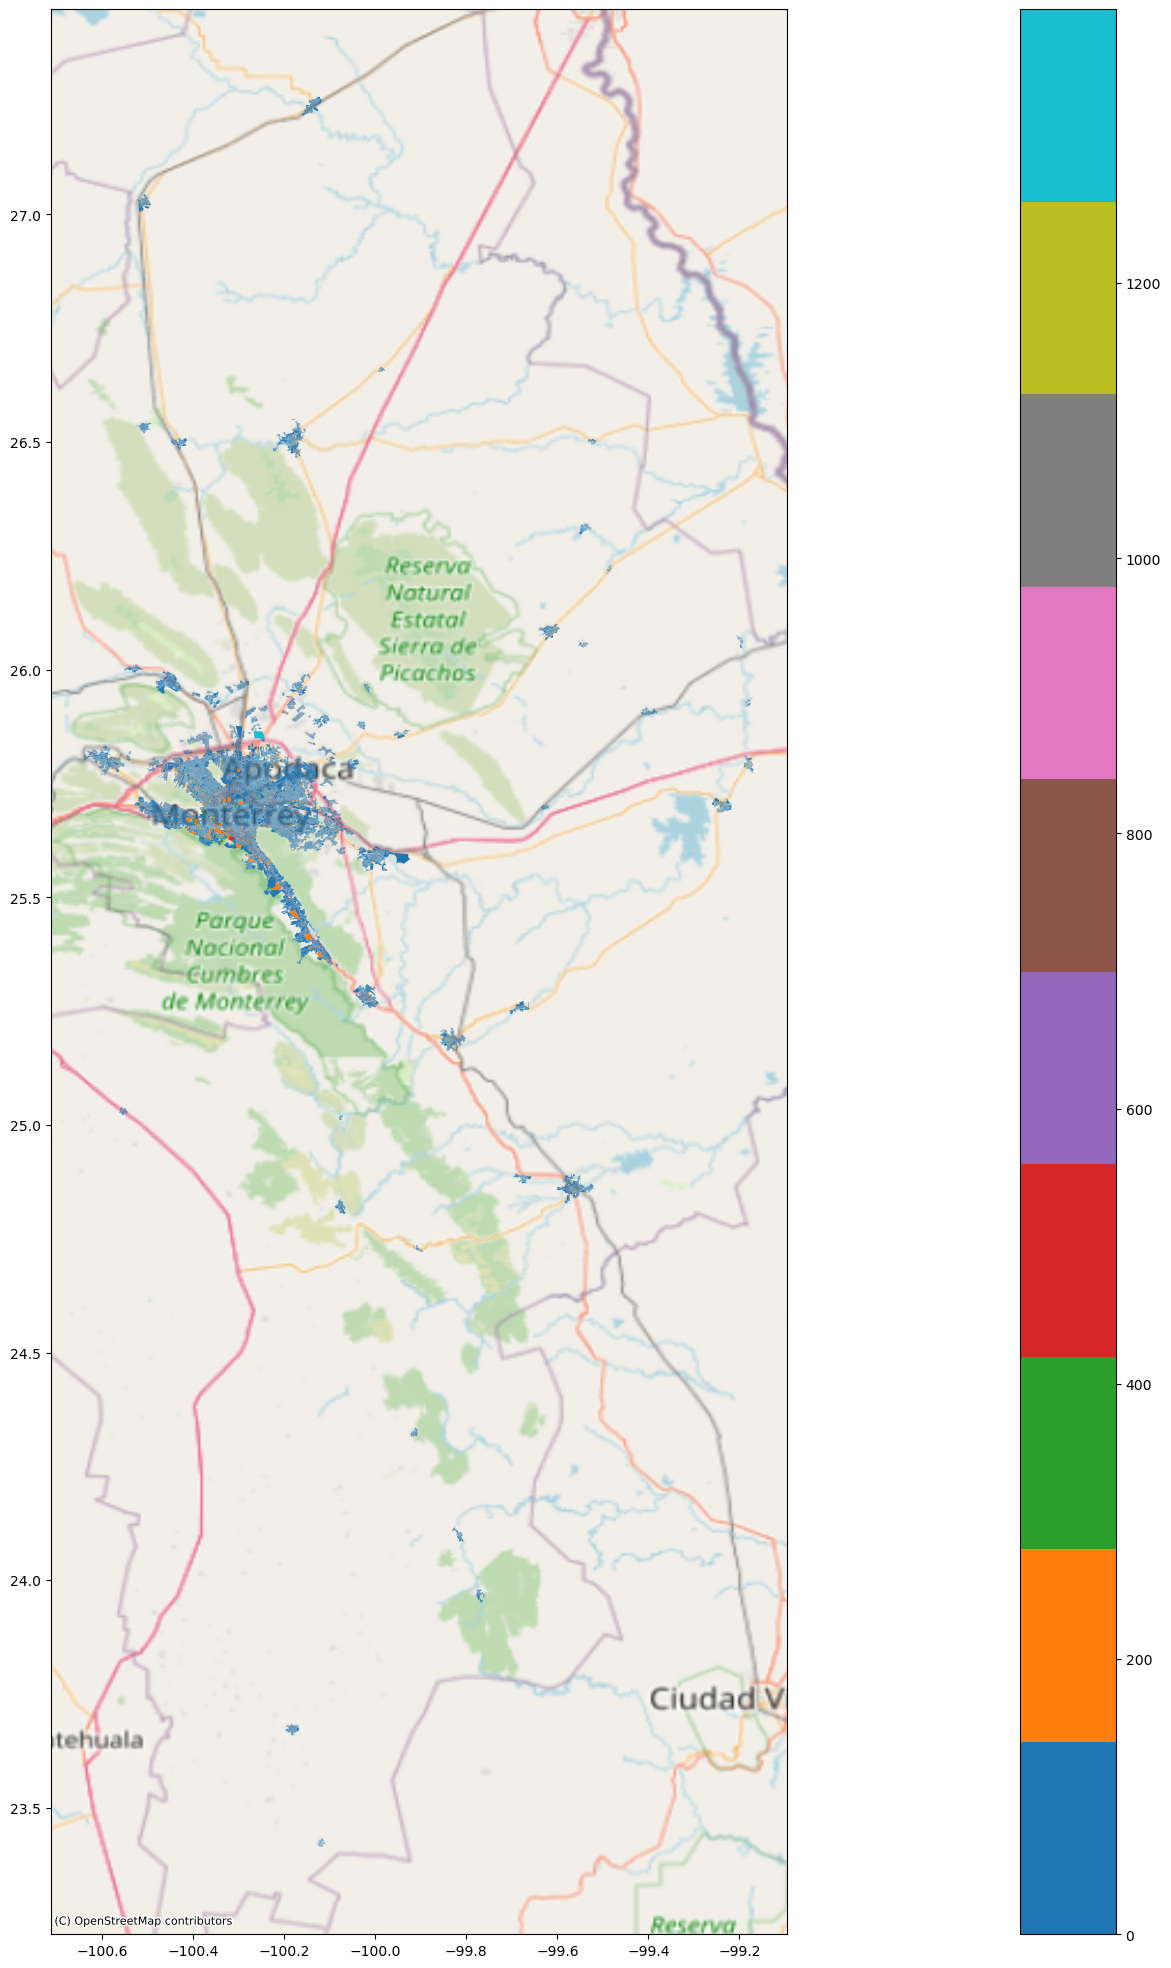

In [12]:
ax = gdf_filtrado.plot("PEA", cmap="tab10", legend=True, figsize=(60, 25))
cx.add_basemap(ax, crs=gdf_filtrado.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
plt.savefig("MAPEO PEA EN NL.png", dpi=300, bbox_inches="tight")

In [13]:
gdf_filtrado[['P12A14NOA', 'P15SEC_IN', 'P15YM_SE_F']] = gdf_filtrado[['P12A14NOA', 'P15SEC_IN', 'P15YM_SE_F']].apply(pd.to_numeric, errors='coerce')
gdf_filtrado['suma_gente_no_escuela'] = gdf_filtrado[['P12A14NOA', 'P15SEC_IN', 'P15YM_SE_F']].sum(axis=1)

In [14]:
gdf_filtrado.value_counts('suma_gente_no_escuela')
gdf_filtrado['suma_gente_no_escuela'] = pd.to_numeric(gdf_filtrado['suma_gente_no_escuela'], errors='coerce')
gdf_filtrado = gdf_filtrado[gdf_filtrado['suma_gente_no_escuela'] != "N/D"]
gdf_filtrado = gdf_filtrado[gdf_filtrado['suma_gente_no_escuela'] != "*"]

In [15]:
gdf_filtrado['suma_gente_no_escuela'] = gdf_filtrado['suma_gente_no_escuela'].astype(int)

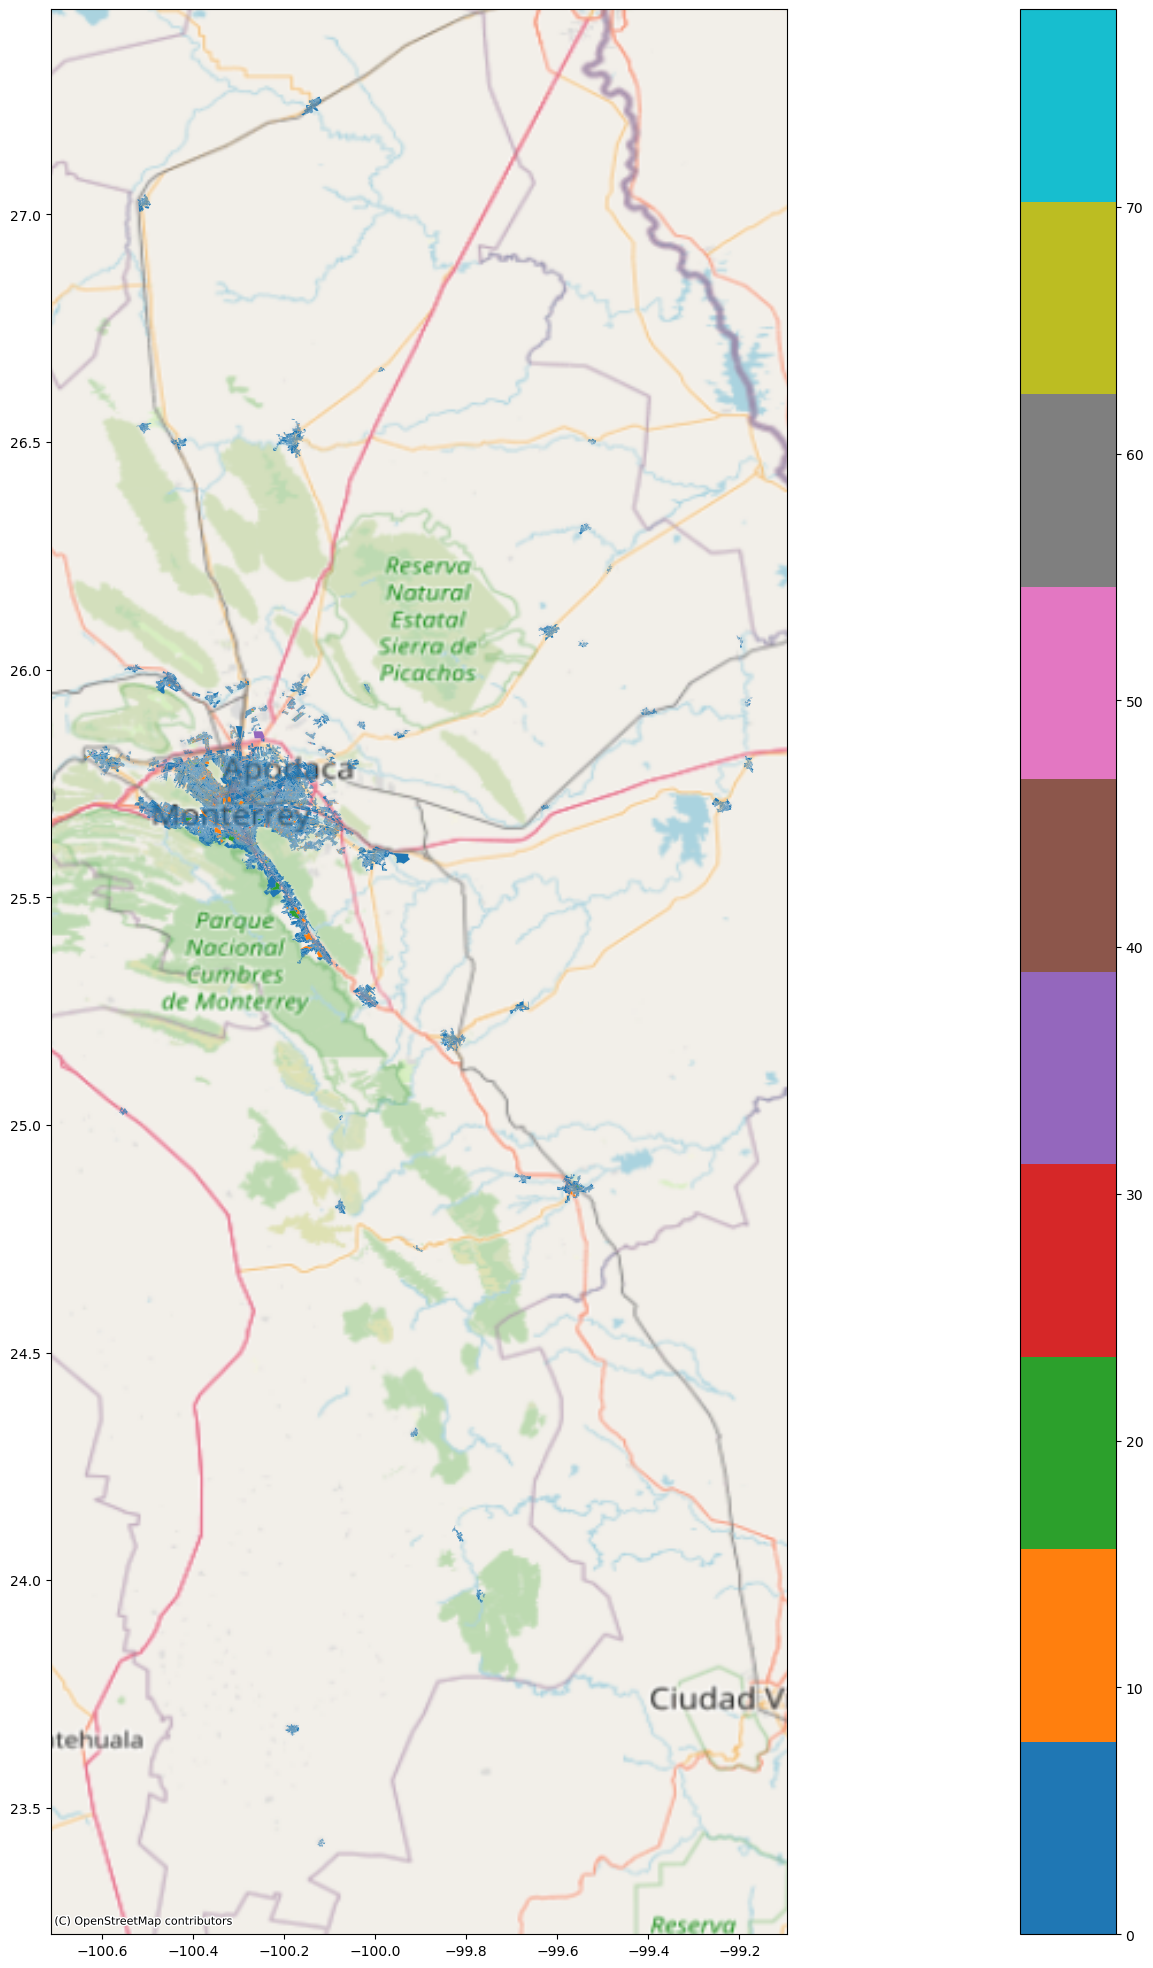

In [16]:
ax = gdf_filtrado.plot('suma_gente_no_escuela', cmap="tab10", legend=True, figsize=(60, 25))
cx.add_basemap(ax, crs=gdf_filtrado.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
plt.savefig("MAPEO GENTE QUE NO VA A LA ESCUELA EN NL.png", dpi=300, bbox_inches="tight")

## LIMPIEZA DE DATOS

In [2]:
df = pd.read_csv('RESAGEBURB_19CSV20[1].csv')
df.shape

(79916, 230)

### Datos Usados
#### Polación de 12 años y más economicamente activa - PEA
#### Población de 12 a 14 años que no asiste a la escuela - P12A14NOA
#### Población de 15 años y más sin escolaridad - P15YM_SE
#### Población de 15 años y más con secundaria incompleta - P15SEC_IN

In [3]:
variables1 = ['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC',
              'AGEB', 'MZA', 'PEA', 'P12A14NOA', 'P15SEC_IN', 'P15YM_SE']
df1 = df[variables1].copy()

columnas_numericas = df1.columns[8:]
df1[columnas_numericas] = df1[columnas_numericas].apply(pd.to_numeric, errors='coerce')

# Eliminación de datos faltantes (* o ND), duplicados, outliers o columnas con solo ceros
df1 = df1.replace('*', pd.NA).replace('N/D', pd.NA).dropna()
df1 = df1.drop_duplicates()
outliers = (df1.iloc[:, 8:] > 4 * df1.iloc[:, 8:].mean()).any(axis=1)  # Defino los outliers como 4 veces mas grande que la media
df1 = df1[~outliers]
ceros = ~df1.iloc[:, 7:].eq(0).all(axis=1)
df1 = df1[ceros]

In [19]:
df1.head(15)

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,PEA,P12A14NOA,P15SEC_IN,P15YM_SE
3,19,Nuevo León,1,Abasolo,1,Total AGEB urbana,0021,0,378.0,7.0,15.0,11.0
8,19,Nuevo León,1,Abasolo,1,Abasolo,0021,5,15.0,0.0,0.0,0.0
12,19,Nuevo León,1,Abasolo,1,Abasolo,0021,9,24.0,0.0,3.0,0.0
13,19,Nuevo León,1,Abasolo,1,Abasolo,0021,10,7.0,0.0,0.0,0.0
14,19,Nuevo León,1,Abasolo,1,Abasolo,0021,11,9.0,0.0,0.0,0.0
15,19,Nuevo León,1,Abasolo,1,Abasolo,0021,12,10.0,0.0,0.0,0.0
16,19,Nuevo León,1,Abasolo,1,Abasolo,0021,13,12.0,0.0,0.0,0.0
17,19,Nuevo León,1,Abasolo,1,Abasolo,0021,14,6.0,0.0,0.0,0.0
19,19,Nuevo León,1,Abasolo,1,Abasolo,0021,16,0.0,0.0,0.0,0.0
21,19,Nuevo León,1,Abasolo,1,Abasolo,0021,18,0.0,0.0,0.0,0.0


## Análisis de Datos

In [20]:
columnas = df1.select_dtypes(include=['int', 'float'])
columnas = columnas.drop(columns=['ENTIDAD', 'MUN', 'LOC', 'MZA'], errors='ignore')
#Medidas de tendencia central:promedio, media, mediana y moda de los datos.
#Medidas de dispersión: rango: máximo - mínimo, varianza, desviación estándar.
Cuantitativas = columnas.describe()
rango = columnas.max() - columnas.min()
varianza = columnas.var()
mediana = columnas.median()
moda = columnas.mode()
moda = columnas.mode()
Cuantitativas.loc['moda'] = moda.iloc[0]
Cuantitativas.loc['mediana'] = mediana
Cuantitativas.loc['rango'] = rango
Cuantitativas.loc['varianza'] = varianza
Cuantitativas

,PEA,P12A14NOA,P15SEC_IN,P15YM_SE
count,34719.000000,34719.000000,34719.000000,34719.000000
mean,33.899853,0.097526,1.036435,0.858608
std,85.245772,0.643127,3.180166,2.803607
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,14.000000,0.000000,0.000000,0.000000
75%,41.000000,0.000000,0.000000,0.000000
max,1296.000000,7.000000,46.000000,38.000000
moda,0.000000,0.000000,0.000000,0.000000
mediana,14.000000,0.000000,0.000000,0.000000


In [21]:
# Tabla de distribución de frecuencia en variables cualitativas
columnas2 = df1.iloc[6:, :8]
for columna in columnas2.select_dtypes(include=['object']).columns:
    Frecuencias = columnas2[columna].value_counts().reset_index()
    Frecuencias.columns = ['Categoría', 'Frecuencia']
    print(columna,":")
    print(Frecuencias)
    print("\n")

NOM_ENT :
    Categoría  Frecuencia
0  Nuevo León       34713


NOM_MUN :
                   Categoría  Frecuencia
0                  Monterrey        7220
1                    Apodaca        3603
2                  Guadalupe        3265
3           General Escobedo        2326
4                     Juárez        2212
5   San Nicolás de los Garza        2193
6                     García        1884
7             Santa Catarina        1506
8     San Pedro Garza García         862
9          Cadereyta Jiménez         743
10                   Linares         621
11              Montemorelos         614
12           Sabinas Hidalgo         597
13                  Santiago         540
14                 Pesquería         535
15            General Zuazua         493
16                 El Carmen         470
17          Salinas Victoria         455
18                   Allende         422
19         Ciénega de Flores         414
20                     China         370
21                   Hid

In [22]:
# Modas en variables cualitativas
columnas2 = df.iloc[6:, :8]
for columna in columnas2.select_dtypes(include=['object']).columns:
    print(columna,":")
    print("Moda:", columnas2[columna].mode()[0])
    print("\n")

NOM_ENT :
Moda: Nuevo León


NOM_MUN :
Moda: Monterrey


NOM_LOC :
Moda: Monterrey


AGEB :
Moda: 0146




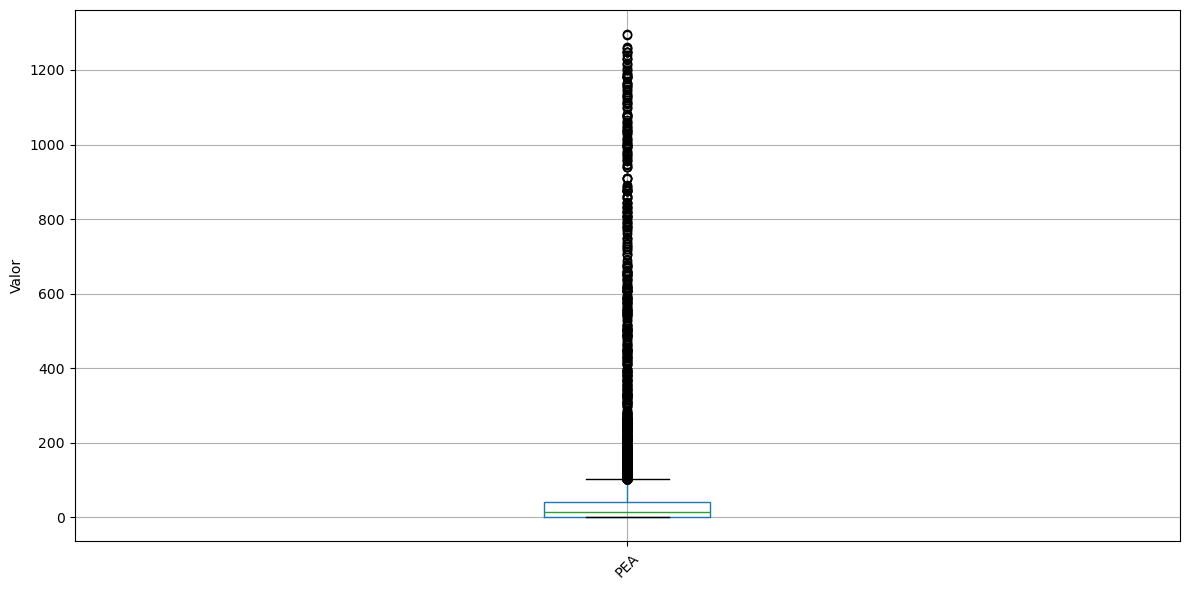

In [23]:
#Boxplots
columnas_grupo1 = columnas.iloc[:, :1]
plt.figure(figsize=(12, 6))
columnas_grupo1.boxplot()
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

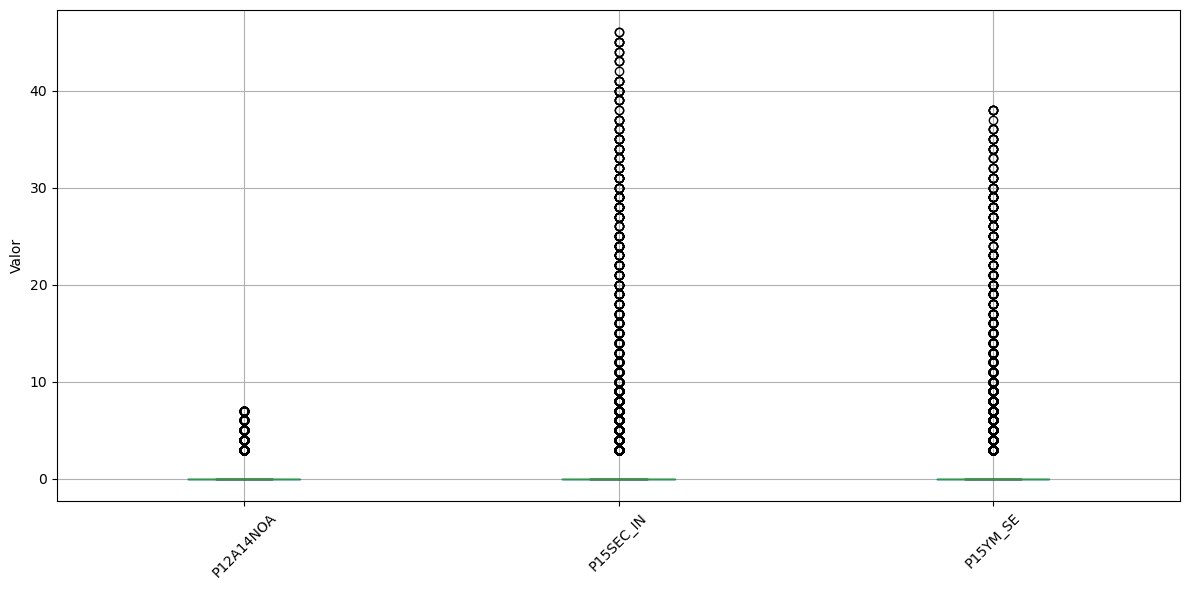

In [24]:
columnas_grupo1 = columnas.iloc[:, 1:]
plt.figure(figsize=(12, 6))
columnas_grupo1.boxplot()
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

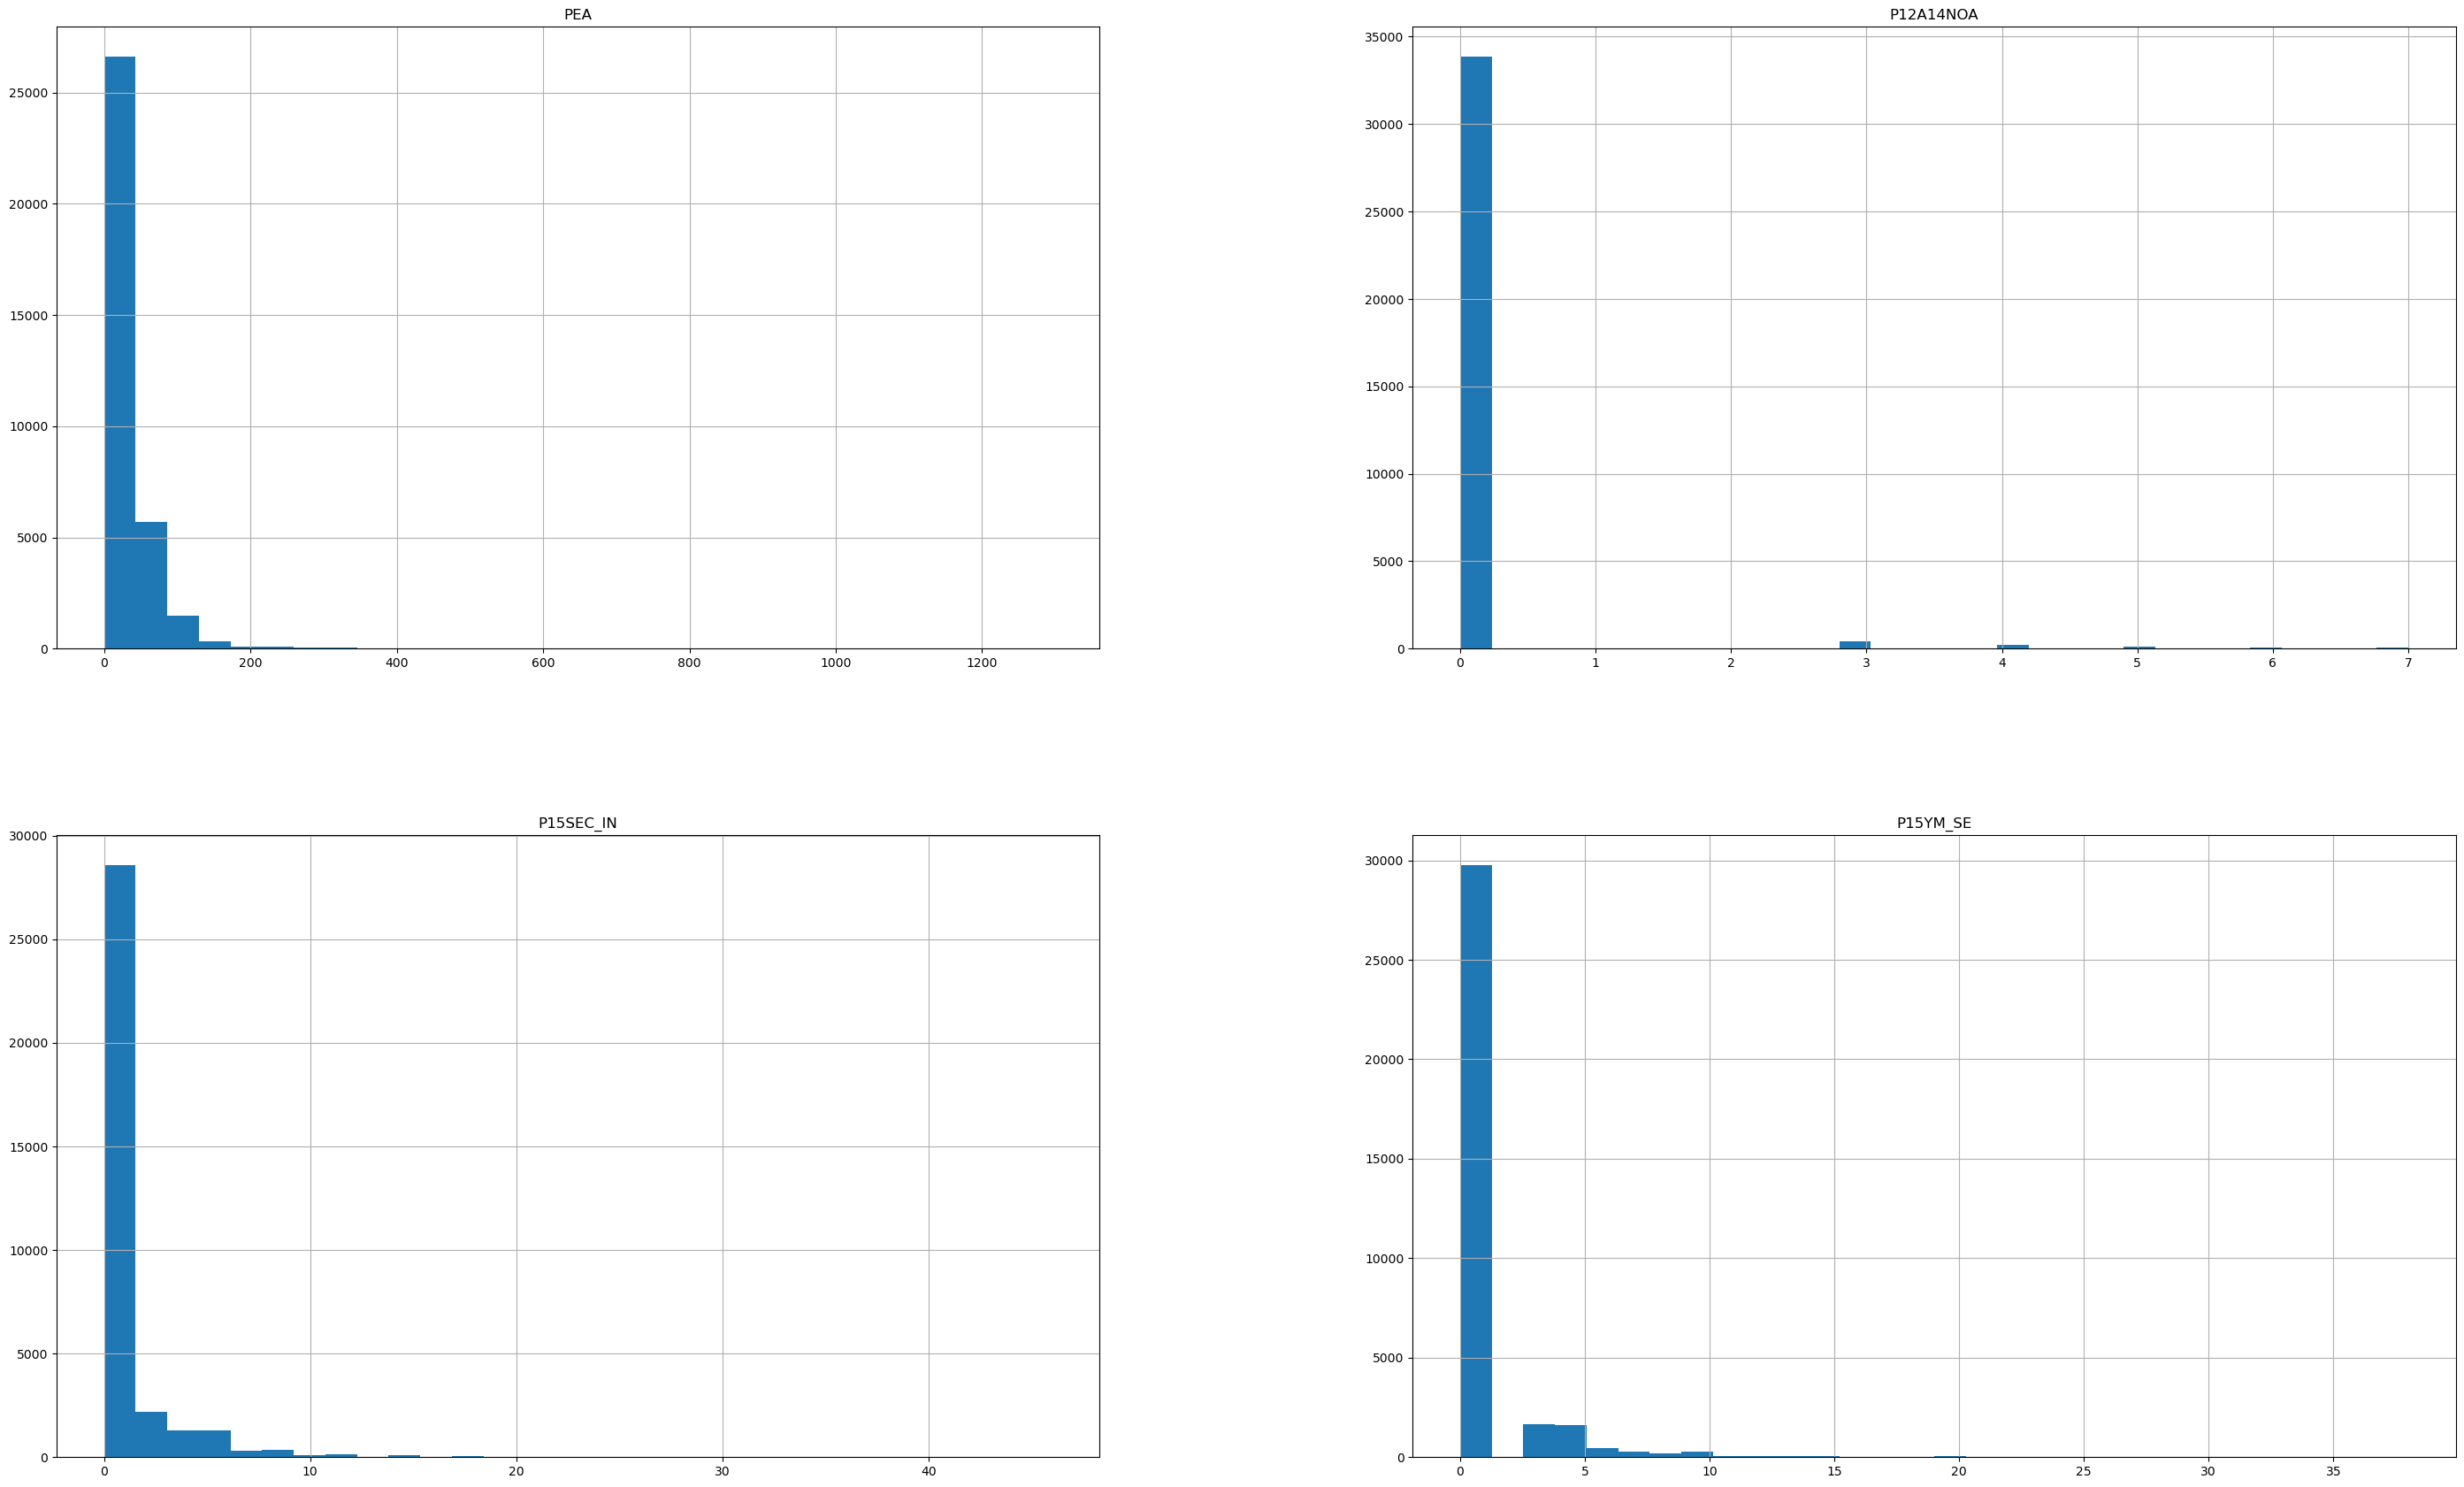

In [25]:
# Histogramas
plt.figure(figsize=(10, 6))
columnas.select_dtypes(include=['float', 'int']).hist(bins=30, figsize=(35, 21))
plt.show()

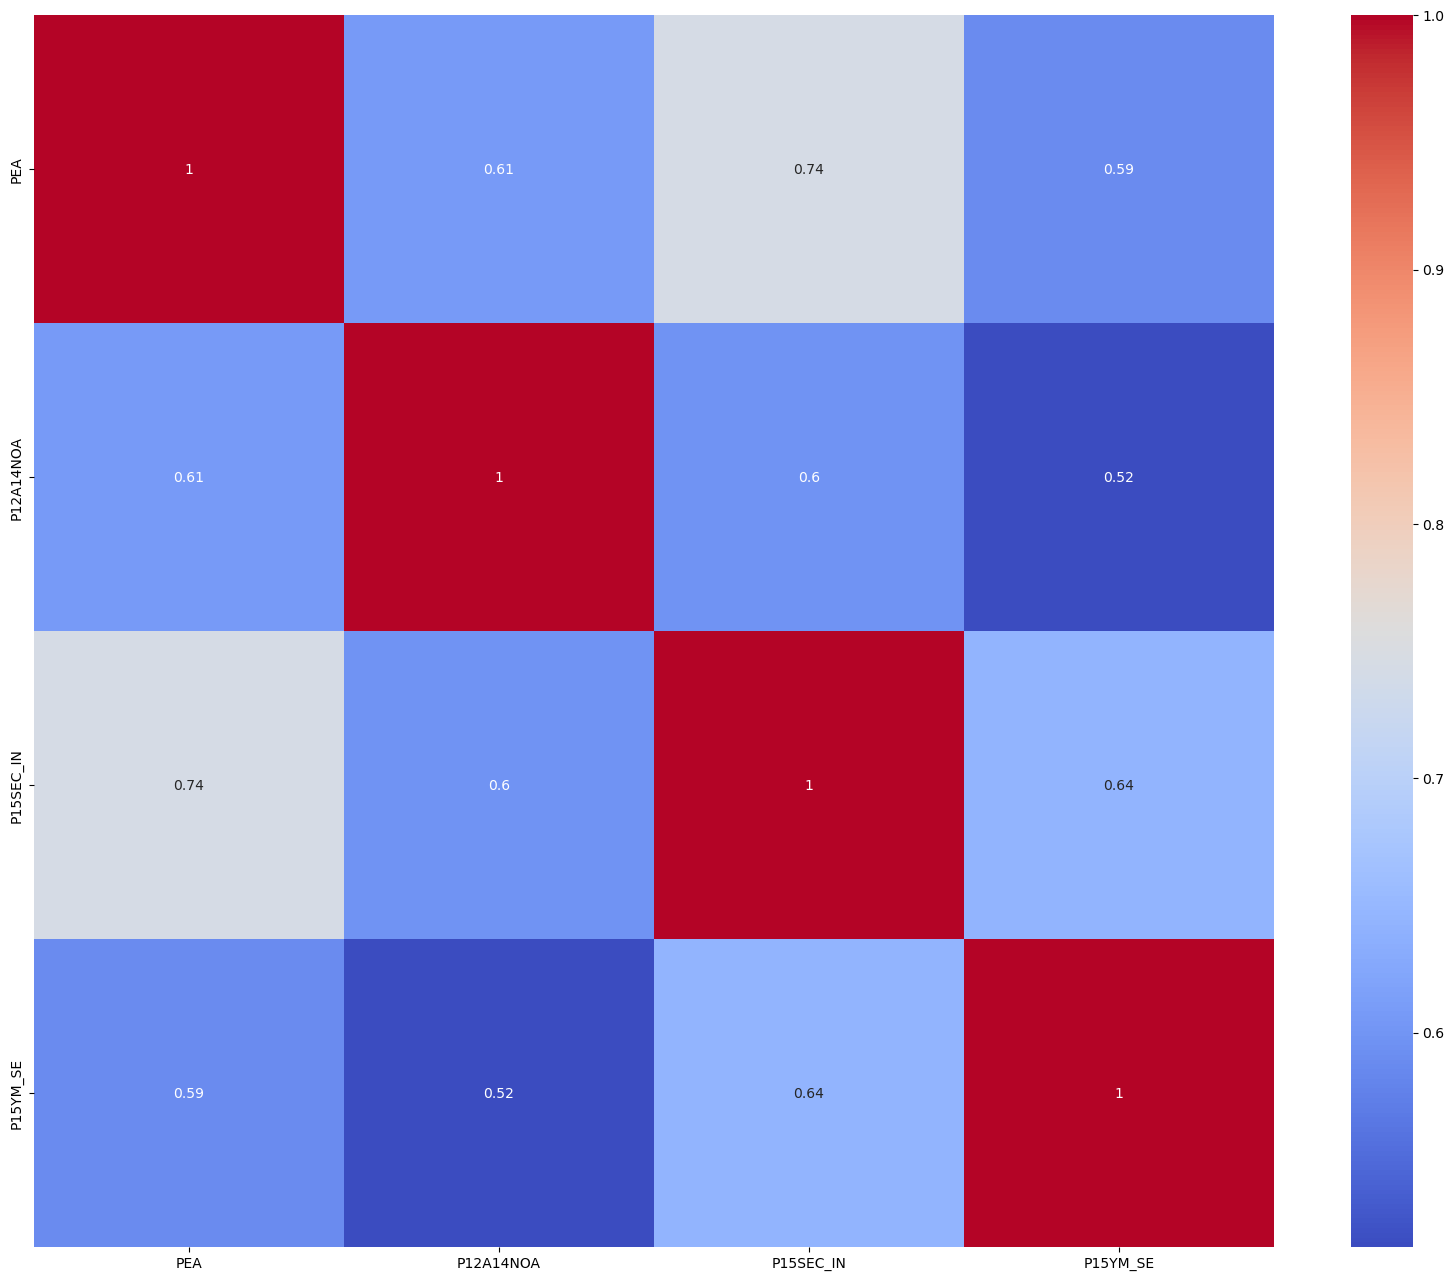

In [26]:
#correlación en mapa de calor
plt.figure(figsize=(20, 16))
sns.heatmap(columnas.corr(), annot=True, cmap='coolwarm')
plt.show()

In [27]:
# Correlación en tabla
columnas.corr()

,PEA,P12A14NOA,P15SEC_IN,P15YM_SE
PEA,1.000000,0.606605,0.744502,0.588208
P12A14NOA,0.606605,1.000000,0.596964,0.515546
P15SEC_IN,0.744502,0.596964,1.000000,0.643347
P15YM_SE,0.588208,0.515546,0.643347,1.000000


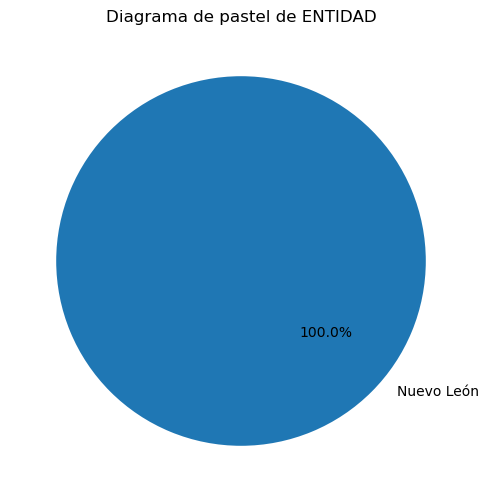

In [28]:
frecuencia_entidad = df1['NOM_ENT'].value_counts()

porcentajes_entidad = 100 * frecuencia_entidad / len(df)

plt.figure(figsize=(6, 6))
plt.pie(porcentajes_entidad, labels=porcentajes_entidad.index, autopct='%1.1f%%', startangle=140)
plt.title('Diagrama de pastel de ENTIDAD')
plt.show()

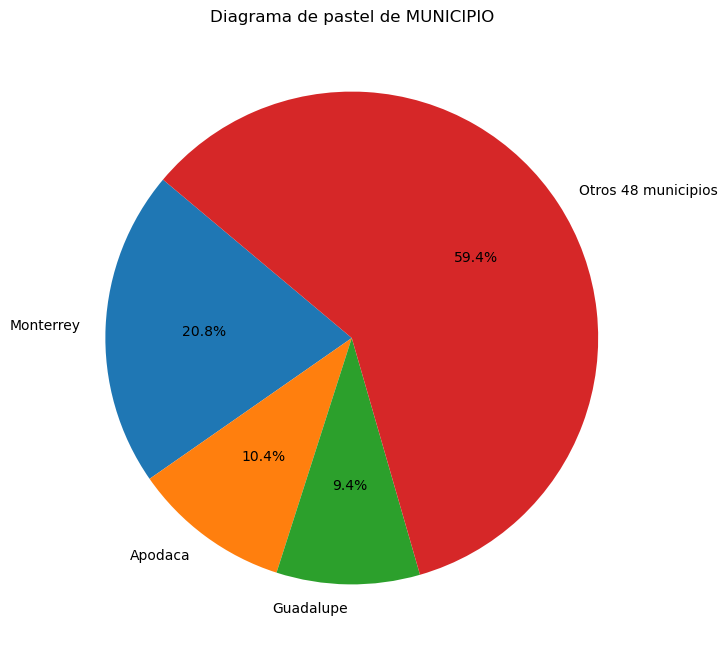

In [29]:
# Calcular la frecuencia de cada categoría
frecuencia_nom_mun = df1['NOM_MUN'].value_counts()

# Calcular los porcentajes para el diagrama de pastel
porcentajes_nom_mun = 100 * frecuencia_nom_mun / len(df)

# Identificar las categorías que representan menos del 3% de los datos
categorias_pequenas = porcentajes_nom_mun[porcentajes_nom_mun < 3].index

# Agrupar las categorías pequeñas en una sola categoría llamada 'Otros'
porcentajes_nom_mun_agrupados = porcentajes_nom_mun.copy()
porcentajes_nom_mun_agrupados.loc[categorias_pequenas] = porcentajes_nom_mun[categorias_pequenas].sum()

# Eliminar las categorías pequeñas del índice
porcentajes_nom_mun_agrupados = porcentajes_nom_mun_agrupados.drop(categorias_pequenas)

# Calcular el número de municipios que se agruparon
num_municipios_agrupados = len(categorias_pequenas)

# Crear una lista de etiquetas para el pie
labels = porcentajes_nom_mun_agrupados.index.tolist()
if len(categorias_pequenas) > 0:
    labels.append(f'Otros {num_municipios_agrupados} municipios')

# Calcular los porcentajes para las categorías agrupadas
porcentajes_agrupados = porcentajes_nom_mun_agrupados.tolist()
if len(categorias_pequenas) > 0:
    porcentajes_agrupados.append(porcentajes_nom_mun[categorias_pequenas].sum())

# Crear el diagrama de pastel
plt.figure(figsize=(8, 8))
plt.pie(porcentajes_agrupados, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Diagrama de pastel de MUNICIPIO')
plt.show()

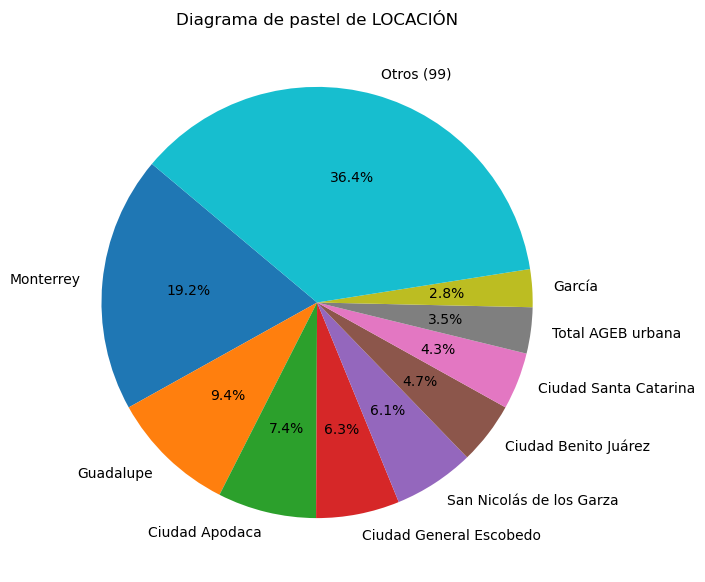

In [30]:
# Calcular la frecuencia de cada categoría
frecuencia_loc = df['NOM_LOC'].value_counts()

# Calcular los porcentajes para el diagrama de pastel
porcentajes_loc = 100 * frecuencia_loc / len(df)

# Identificar las categorías que representan menos del 2.5% de los datos
categorias_pequenas = porcentajes_loc[porcentajes_loc < 2.5].index

# Agrupar las categorías pequeñas en una sola categoría llamada 'Otros'
porcentajes_loc_agrupados = porcentajes_loc.copy()
porcentajes_loc_agrupados.loc[categorias_pequenas] = porcentajes_loc[categorias_pequenas].sum()

# Eliminar las categorías pequeñas del índice
porcentajes_loc_agrupados = porcentajes_loc_agrupados.drop(categorias_pequenas)

# Calcular el número de categorías que se agruparon como "Otros"
num_otros = len(categorias_pequenas)

# Crear una lista de etiquetas para el pie
labels = porcentajes_loc_agrupados.index.tolist()
if num_otros > 0:
    labels.append(f'Otros ({num_otros})')

# Calcular los porcentajes para las categorías agrupadas
porcentajes_agrupados = porcentajes_loc_agrupados.tolist()
if num_otros > 0:
    porcentajes_agrupados.append(porcentajes_loc[categorias_pequenas].sum())

# Crear el diagrama de pastel
plt.figure(figsize=(7, 7))
plt.pie(porcentajes_agrupados, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Diagrama de pastel de LOCACIÓN')
plt.show()

## GENERACIÓN DE MODELOS DE APRENDIZAJE

#### Modelos en base a "TRABAJO-NO ESCUELA"

In [31]:
variables1 = ['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC',
              'AGEB', 'MZA', 'PEA', 'P12A14NOA', 'P15SEC_IN', 'P15YM_SE']
df1_1 = df1[variables1].copy()

In [32]:
df1_1.shape

(34719, 12)

In [33]:
columnas_modelos = ['P12A14NOA', 'P15SEC_IN', 'P15YM_SE']

y1 = df1_1[['PEA']].copy()
x1 = df1_1[columnas_modelos].copy()

In [34]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.2, random_state = 777)

In [35]:
y1_test.head(10)

,PEA
58452,0.0
77148,0.0
33684,77.0
5016,4.0
2905,53.0
31176,17.0
23541,13.0
74839,35.0
8033,35.0
42721,19.0


### REGRESIÓN LINEAL

In [36]:
warnings.filterwarnings("ignore")

parametros = {}

print("REGRESIÓN LINEAL Personas Economicamente Activas: ")

grid_search_pea = GridSearchCV(estimator=LinearRegression(), param_grid=parametros, cv=5, verbose = 1, scoring='r2')
grid_search_pea.fit(x1_train, y1_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y1_pred_gs = mejor_modelo_pea.predict(x1_test)

y1_pred_gs = y1_pred_gs.flatten() if isinstance(y1_pred_gs, np.ndarray) else y1_pred_gs.values.flatten()
y1_test = y1_test.flatten() if isinstance(y1_test, np.ndarray) else y1_test.values.flatten()

# Predicciones y valores reales
predicciones_reales = pd.DataFrame({'Predicción': y1_pred_gs[:10], 'Valor Real': y1_test[:10]})
print(predicciones_reales)

# Error Cuadrado Medio
print("Mean squared error: %.3f" % mean_squared_error(y1_test, y1_pred_gs))
# Puntaje de Varianza.
print('Variance score: %.3f' % r2_score(y1_test, y1_pred_gs))

REGRESIÓN LINEAL Personas Economicamente Activas: 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   Predicción  Valor Real
0   12.720063         0.0
1   12.720063         0.0
2   81.447910        77.0
3   12.720063         4.0
4   12.720063        53.0
5   12.720063        17.0
6   12.720063        13.0
7   12.720063        35.0
8   12.720063        35.0
9   12.720063        19.0
Mean squared error: 2631.583
Variance score: 0.601


### Regresión Logistica

In [37]:
warnings.filterwarnings("ignore")
parametros = {}

print("REGRESIÓN LOGISTICA Personas Economicamente Activas: ")

grid_search_pea = GridSearchCV(estimator=LogisticRegression(), param_grid=parametros, cv=5, verbose = 1, scoring='r2')
grid_search_pea.fit(x1_train, y1_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y1_pred_gs = mejor_modelo_pea.predict(x1_test)

y1_pred_gs = y1_pred_gs.flatten() if isinstance(y1_pred_gs, np.ndarray) else y1_pred_gs.values.flatten()
y1_test = y1_test.flatten() if isinstance(y1_test, np.ndarray) else y1_test.values.flatten()

# Predicciones y valores reales
predicciones_reales = pd.DataFrame({'Predicción': y1_pred_gs[:10], 'Valor Real': y1_test[:10]})
print(predicciones_reales)

# Error Cuadrado Medio
print("Mean squared error: %.3f" % mean_squared_error(y1_test, y1_pred_gs))
# Puntaje de Varianza.
print('Variance score: %.3f' % r2_score(y1_test, y1_pred_gs))

REGRESIÓN LOGISTICA Personas Economicamente Activas: 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   Predicción  Valor Real
0         0.0         0.0
1         0.0         0.0
2        46.0        77.0
3         0.0         4.0
4         0.0        53.0
5         0.0        17.0
6         0.0        13.0
7         0.0        35.0
8         0.0        35.0
9         0.0        19.0
Mean squared error: 4095.843
Variance score: 0.379


### Arboles de Decisión

In [38]:
warnings.filterwarnings("ignore")
parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10, 12, 15],
    'max_features': [3, 6, 9, 12]
}

print("ARBOLES DE DECISIÓN Personas Economicamente Activas: ")

grid_search_pea = GridSearchCV(estimator=DecisionTreeClassifier(random_state=777), param_grid=parametros, cv=5, verbose = 1, scoring='r2')
grid_search_pea.fit(x1_train, y1_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y1_pred_gs = mejor_modelo_pea.predict(x1_test)

y1_pred_gs = y1_pred_gs.flatten() if isinstance(y1_pred_gs, np.ndarray) else y1_pred_gs.values.flatten()
y1_test = y1_test.flatten() if isinstance(y1_test, np.ndarray) else y1_test.values.flatten()

# Predicciones y valores reales
predicciones_reales = pd.DataFrame({'Predicción': y1_pred_gs[:10], 'Valor Real': y1_test[:10]})
print(predicciones_reales)

# Error Cuadrado Medio
print("Mean squared error: %.3f" % mean_squared_error(y1_test, y1_pred_gs))
# Puntaje de Varianza.
print('Variance score: %.3f' % r2_score(y1_test, y1_pred_gs))

ARBOLES DE DECISIÓN Personas Economicamente Activas: 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   Predicción  Valor Real
0         0.0         0.0
1         0.0         0.0
2        44.0        77.0
3         0.0         4.0
4         0.0        53.0
5         0.0        17.0
6         0.0        13.0
7         0.0        35.0
8         0.0        35.0
9         0.0        19.0
Mean squared error: 4397.386
Variance score: 0.334


## Bosques Aleatorios

In [39]:
warnings.filterwarnings("ignore")

parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10, 12, 15],
    'max_features': [3, 6, 9, 12]
}

print("BOSQUES ALEATORIOS Personas Economicamente Activas: ")

grid_search_pea = GridSearchCV(estimator=RandomForestRegressor(random_state=777), param_grid=parametros, cv=5, verbose = 1, scoring='r2')
grid_search_pea.fit(x1_train, y1_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y1_pred_gs = mejor_modelo_pea.predict(x1_test)

y1_pred_gs = y1_pred_gs.flatten() if isinstance(y1_pred_gs, np.ndarray) else y1_pred_gs.values.flatten()
y1_test = y1_test.flatten() if isinstance(y1_test, np.ndarray) else y1_test.values.flatten()

# Predicciones y valores reales
predicciones_reales = pd.DataFrame({'Predicción': y1_pred_gs[:10], 'Valor Real': y1_test[:10]})
print(predicciones_reales)

# Error Cuadrado Medio
print("Mean squared error: %.3f" % mean_squared_error(y1_test, y1_pred_gs))
# Puntaje de Varianza.
print('Variance score: %.3f' % r2_score(y1_test, y1_pred_gs))

BOSQUES ALEATORIOS Personas Economicamente Activas: 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   Predicción  Valor Real
0   15.287838         0.0
1   15.287838         0.0
2   63.702178        77.0
3   15.287838         4.0
4   15.287838        53.0
5   15.287838        17.0
6   15.287838        13.0
7   15.287838        35.0
8   15.287838        35.0
9   15.287838        19.0
Mean squared error: 3230.322
Variance score: 0.511


#### Modelos en base a " NO TRABAJO-ESCUELA"

### Datos Usados
#### Polación de 12 años y más no economicamente activa - PE_INAC
#### Población de 15 a 17 años y más que si asiste a la escuela - P15A17A
#### Población de 18 a 24 años y más que si asiste a la escuela - P18A24A
#### Población de 18 años y más con educación posbásica - P18YM_PBca

In [4]:
variables2 = ['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC',
              'AGEB', 'MZA', 'PE_INAC',  'P15A17A', 'P18A24A', 'P18YM_PB']
df2 = df[variables2].copy()

columnas_numericas = df2.columns[8:]
df2[columnas_numericas] = df2[columnas_numericas].apply(pd.to_numeric, errors='coerce')

# Eliminación de datos faltantes (* o ND), duplicados, outliers o columnas con solo ceros
df2 = df2.replace('*', pd.NA).replace('N/D', pd.NA).dropna()
df2 = df2.drop_duplicates()
outliers = (df2.iloc[:, 8:] > 4 * df2.iloc[:, 8:].mean()).any(axis=1)  # Defino los outliers como 4 veces mas grande que la media
df2 = df2[~outliers]
ceros = ~df2.iloc[:, 7:].eq(0).all(axis=1)
df2 = df2[ceros]
df2.shape

(39855, 12)

In [5]:
columnas_modelos2 = ['P15A17A', 'P18A24A', 'P18YM_PB']

y2 = df2[['PE_INAC']].copy()
x2 = df2[columnas_modelos2].copy()

In [42]:
# Correlación en tabla
df2.iloc[:, 8:].corr()

,PE_INAC,P15A17A,P18A24A,P18YM_PB
PE_INAC,1.000000,0.895258,0.794548,0.863738
P15A17A,0.895258,1.000000,0.810638,0.824156
P18A24A,0.794548,0.810638,1.000000,0.877688
P18YM_PB,0.863738,0.824156,0.877688,1.000000


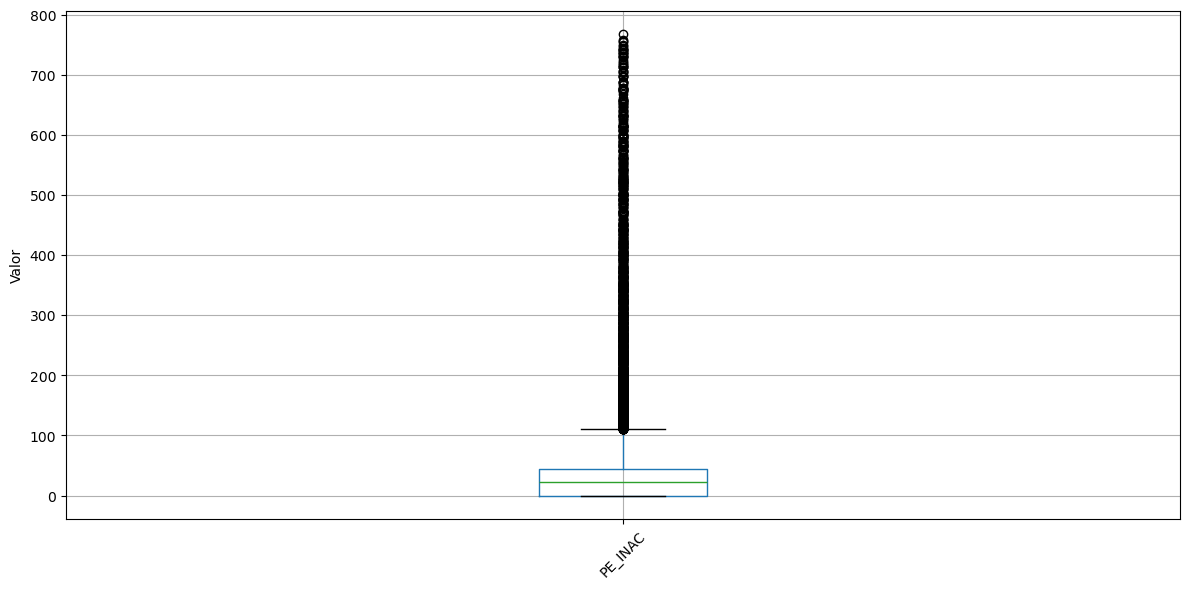

In [43]:
columnas2 = df2.select_dtypes(include=['int', 'float'])
columnas2 = columnas2.drop(columns=['ENTIDAD', 'MUN', 'LOC', 'MZA'], errors='ignore')
#Boxplots
columnas_grupo1_1 = columnas2.iloc[:, :1]
plt.figure(figsize=(12, 6))
columnas_grupo1_1.boxplot()
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

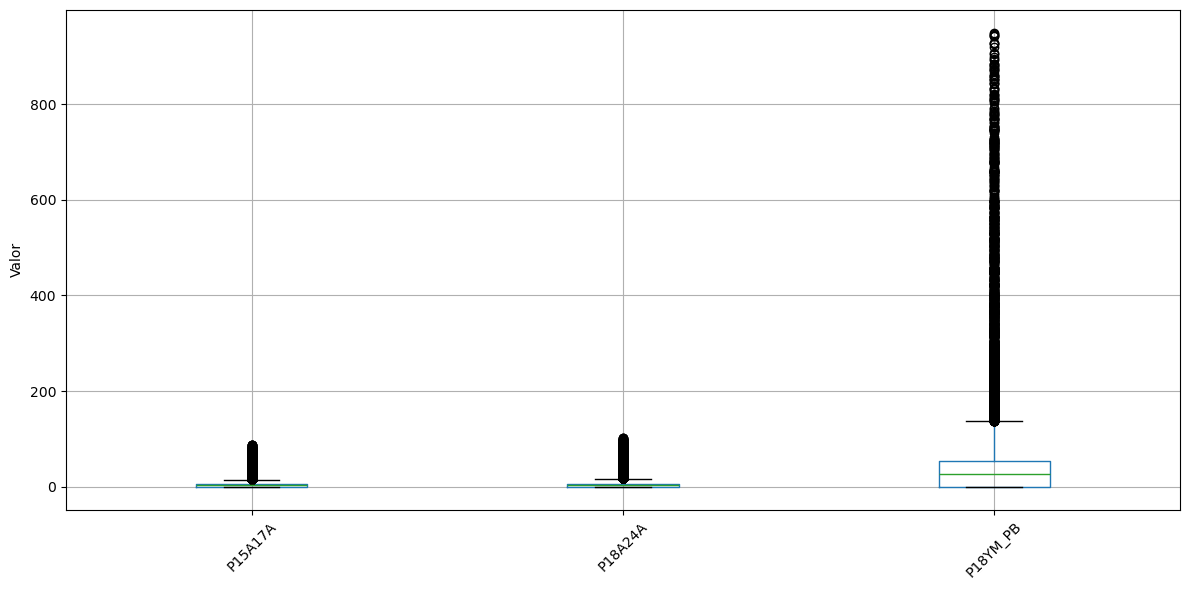

In [44]:
columnas_grupo1_1 = columnas2.iloc[:, 1:]
plt.figure(figsize=(12, 6))
columnas_grupo1_1.boxplot()
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2, random_state = 777)

In [27]:
y2_test.head(10)

,PE_INAC
24851,49.0
77743,37.0
31219,0.0
7465,28.0
37793,41.0
29208,0.0
53363,0.0
62782,21.0
77935,40.0
50018,0.0


### REGRESIÓN LINEAL

In [28]:
warnings.filterwarnings("ignore")

parametros = {}

print("REGRESIÓN LINEAL Personas Economicamente Inactivas: ")

grid_search_pea = GridSearchCV(estimator=LinearRegression(), param_grid=parametros, cv=5, verbose = 1, scoring='r2')
grid_search_pea.fit(x2_train, y2_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y2_pred_gs = mejor_modelo_pea.predict(x2_test)

y2_pred_gs = y2_pred_gs.flatten() if isinstance(y2_pred_gs, np.ndarray) else y2_pred_gs.values.flatten()
y2_test = y2_test.flatten() if isinstance(y2_test, np.ndarray) else y2_test.values.flatten()

# Predicciones y valores reales
predicciones_reales = pd.DataFrame({'Predicción': y2_pred_gs[:10], 'Valor Real': y2_test[:10]})
print(predicciones_reales)

# Error Cuadrado Medio
print("Mean squared error: %.3f" % mean_squared_error(y2_test, y2_pred_gs))
# Puntaje de Varianza.
print('Variance score: %.3f' % r2_score(y2_test, y2_pred_gs))
R2_1 = r2_score(y2_test, y2_pred_gs)

REGRESIÓN LINEAL Personas Economicamente Inactivas: 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   Predicción  Valor Real
0   22.533858        49.0
1   52.351914        37.0
2   -0.428470         0.0
3   29.100377        28.0
4   29.371686        41.0
5   -0.428470         0.0
6   -0.428470         0.0
7   21.103834        21.0
8   80.446502        40.0
9   -0.428470         0.0
Mean squared error: 597.148
Variance score: 0.841


### REGRESIÓN LOGISTICA

In [48]:
warnings.filterwarnings("ignore")
parametros = {}

print("REGRESIÓN LOGISTICA Personas Economicamente Inactivas: ")

grid_search_pea = GridSearchCV(estimator=LogisticRegression(), param_grid=parametros, cv=5, verbose = 1, scoring='r2')
grid_search_pea.fit(x2_train, y2_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y2_pred_gs = mejor_modelo_pea.predict(x2_test)

y2_pred_gs = y2_pred_gs.flatten() if isinstance(y2_pred_gs, np.ndarray) else y2_pred_gs.values.flatten()
y2_test = y2_test.flatten() if isinstance(y2_test, np.ndarray) else y2_test.values.flatten()

# Predicciones y valores reales
predicciones_reales = pd.DataFrame({'Predicción': y2_pred_gs[:10], 'Valor Real': y2_test[:10]})
print(predicciones_reales)

# Error Cuadrado Medio
print("Mean squared error: %.3f" % mean_squared_error(y2_test, y2_pred_gs))
# Puntaje de Varianza.
print('Variance score: %.3f' % r2_score(y2_test, y2_pred_gs))

REGRESIÓN LOGISTICA Personas Economicamente Inactivas: 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   Predicción  Valor Real
0        37.0        49.0
1        40.0        37.0
2         0.0         0.0
3        37.0        28.0
4        40.0        41.0
5         0.0         0.0
6         0.0         0.0
7        37.0        21.0
8        37.0        40.0
9         0.0         0.0
Mean squared error: 3246.798
Variance score: 0.137


### ARBOLES DE DECISIÓN

In [49]:
warnings.filterwarnings("ignore")
parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10, 12, 15],
    'max_features': [3, 6, 9, 12]
}

print("ARBOLES DE DECISIÓN Personas Economicamente Inactivas: ")

grid_search_pea = GridSearchCV(estimator=DecisionTreeClassifier(random_state=777), param_grid=parametros, cv=5, verbose = 1, scoring='r2')
grid_search_pea.fit(x2_train, y2_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y2_pred_gs = mejor_modelo_pea.predict(x2_test)

y2_pred_gs = y2_pred_gs.flatten() if isinstance(y2_pred_gs, np.ndarray) else y2_pred_gs.values.flatten()
y2_test = y2_test.flatten() if isinstance(y2_test, np.ndarray) else y2_test.values.flatten()

# Predicciones y valores reales
predicciones_reales = pd.DataFrame({'Predicción': y2_pred_gs[:10], 'Valor Real': y2_test[:10]})
print(predicciones_reales)

# Error Cuadrado Medio
print("Mean squared error: %.3f" % mean_squared_error(y2_test, y2_pred_gs))
# Puntaje de Varianza.
print('Variance score: %.3f' % r2_score(y2_test, y2_pred_gs))

ARBOLES DE DECISIÓN Personas Economicamente Inactivas: 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   Predicción  Valor Real
0        21.0        49.0
1        60.0        37.0
2         0.0         0.0
3        16.0        28.0
4        22.0        41.0
5         0.0         0.0
6         0.0         0.0
7        21.0        21.0
8        61.0        40.0
9         0.0         0.0
Mean squared error: 948.913
Variance score: 0.748


### BOSQUES ALEATORIOS

In [9]:
warnings.filterwarnings("ignore")

parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10, 12, 15],
    'max_features': [3, 6, 9, 12]
}

print("BOSQUES ALEATORIOS Personas Economicamente Inactivas: ")

grid_search_pea = GridSearchCV(estimator=RandomForestRegressor(random_state=777), param_grid=parametros, cv=5, verbose = 1, scoring='r2')
grid_search_pea.fit(x2_train, y2_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y2_pred_gs = mejor_modelo_pea.predict(x2_test)

y2_pred_gs = y2_pred_gs.flatten() if isinstance(y2_pred_gs, np.ndarray) else y2_pred_gs.values.flatten()
y2_test = y2_test.flatten() if isinstance(y2_test, np.ndarray) else y2_test.values.flatten()

# Predicciones y valores reales
predicciones_reales = pd.DataFrame({'Predicción': y2_pred_gs[:10], 'Valor Real': y2_test[:10]})
print(predicciones_reales)

# Error Cuadrado Medio
print("Mean squared error: %.3f" % mean_squared_error(y2_test, y2_pred_gs))
# Puntaje de Varianza.
print('Variance score: %.3f' % r2_score(y2_test, y2_pred_gs))
r2_1 = r2_score(y2_test, y2_pred_gs)

BOSQUES ALEATORIOS Personas Economicamente Inactivas: 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   Predicción  Valor Real
0   27.086366        49.0
1   55.897333        37.0
2    0.150033         0.0
3   27.256730        28.0
4   43.771452        41.0
5    0.150033         0.0
6    0.150033         0.0
7   28.043648        21.0
8   57.192500        40.0
9    0.150033         0.0
Mean squared error: 623.376
Variance score: 0.834


## IMPLEMENTACION DE METODOS DE CLASIFICACIÓN

In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34719 entries, 3 to 79915
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ENTIDAD    34719 non-null  int64  
 1   NOM_ENT    34719 non-null  object 
 2   MUN        34719 non-null  int64  
 3   NOM_MUN    34719 non-null  object 
 4   LOC        34719 non-null  int64  
 5   NOM_LOC    34719 non-null  object 
 6   AGEB       34719 non-null  object 
 7   MZA        34719 non-null  int64  
 8   PEA        34719 non-null  float64
 9   P12A14NOA  34719 non-null  float64
 10  P15SEC_IN  34719 non-null  float64
 11  P15YM_SE   34719 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 3.4+ MB


In [52]:
tabla_variables_pea = df1['PEA'].value_counts().reset_index()
tabla_variables_pea.columns = ['Valor', 'Frecuencia']
print(tabla_variables_pea)

     Valor  Frecuencia
0      0.0       11258
1      6.0         619
2      8.0         584
3      7.0         570
4      5.0         566
..     ...         ...
590  409.0           1
591  303.0           1
592  484.0           1
593  677.0           1
594  276.0           1

[595 rows x 2 columns]


In [53]:
df1['PEA'].mean()

33.89985310636827

In [54]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39855 entries, 3 to 79915
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ENTIDAD   39855 non-null  int64  
 1   NOM_ENT   39855 non-null  object 
 2   MUN       39855 non-null  int64  
 3   NOM_MUN   39855 non-null  object 
 4   LOC       39855 non-null  int64  
 5   NOM_LOC   39855 non-null  object 
 6   AGEB      39855 non-null  object 
 7   MZA       39855 non-null  int64  
 8   PE_INAC   39855 non-null  float64
 9   P15A17A   39855 non-null  float64
 10  P18A24A   39855 non-null  float64
 11  P18YM_PB  39855 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 4.0+ MB


In [55]:
tabla_variables_peinac = df2['PE_INAC'].value_counts().reset_index()
tabla_variables_peinac.columns = ['Valor', 'Frecuencia']
print(tabla_variables_peinac)

     Valor  Frecuencia
0      0.0       11403
1      5.0         545
2      4.0         526
3     31.0         516
4     35.0         515
..     ...         ...
564  383.0           1
565  388.0           1
566  756.0           1
567  220.0           1
568  651.0           1

[569 rows x 2 columns]


In [56]:
df2['PE_INAC'].mean()

33.733759879563415

In [57]:
def clasificar_PEAs(valor):
    if valor >= 0 and valor <= 0:
        return "NULO"
    elif valor >= 1 and valor <= 30:
        return "Pocas"
    else:
        return "Muchas"

df1['clas_pers_PEA'] = df1['PEA'].apply(clasificar_PEAs)

tabla_variables1 = df1['clas_pers_PEA'].value_counts().reset_index()
tabla_variables1.columns = ['Valor', 'Frecuencia']
print(tabla_variables1)

    Valor  Frecuencia
0   Pocas       11991
1  Muchas       11470
2    NULO       11258


In [10]:
def clasificar_PEINAC(valor):
    if valor >= 0 and valor <= 0:
        return "NULO"
    elif valor >= 1 and valor <= 35:
        return "Pocas"
    else:
        return "Muchas"

df2['clas_pers_PEINAC'] = df2['PE_INAC'].apply(clasificar_PEINAC)

tabla_variables2 = df2['clas_pers_PEINAC'].value_counts().reset_index()
tabla_variables2.columns = ['Valor', 'Frecuencia']
print(tabla_variables2)

    Valor  Frecuencia
0   Pocas       14516
1  Muchas       13936
2    NULO       11403


### Librerias

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

### Código de Clasificación para PEA

In [59]:
columnas_modelos = ['P12A14NOA', 'P15SEC_IN', 'P15YM_SE']

y1_1 = df1[['clas_pers_PEA']].copy()
x1_1 = df1[columnas_modelos].copy()

In [60]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1_1, y1_1, test_size = 0.2, random_state = 777)

In [61]:
y1_test.head(10)

,clas_pers_PEA
58452,NULO
77148,NULO
33684,Muchas
5016,Pocas
2905,Muchas
31176,Pocas
23541,Pocas
74839,Muchas
8033,Muchas
42721,Pocas


In [64]:
warnings.filterwarnings("ignore")

parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10, 12, 15],
    'max_features': [3, 6, 9, 12]
}

print("BOSQUES ALEATORIOS Personas Economicamente Activas (CLASIFICACION): ")

grid_search_pea = GridSearchCV(estimator=RandomForestClassifier(random_state=777), param_grid=parameters, cv=5, verbose=1, scoring='accuracy')
grid_search_pea.fit(x1_train, y1_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y1_pred_gs = mejor_modelo_pea.predict(x1_test)

# Predicciones y valores reales
print("Predicciones vs Valores reales:")
print(classification_report(y1_test, y1_pred_gs))

# Exactitud
print("Exactitud:", accuracy_score(y1_test, y1_pred_gs))

BOSQUES ALEATORIOS Personas Economicamente Activas (CLASIFICACION): 
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Predicciones vs Valores reales:
              precision    recall  f1-score   support

      Muchas       0.89      0.51      0.65      2323
        NULO       0.42      1.00      0.59      2264
       Pocas       0.51      0.04      0.08      2357

    accuracy                           0.51      6944
   macro avg       0.61      0.52      0.44      6944
weighted avg       0.61      0.51      0.44      6944

Exactitud: 0.5123847926267281


### Código de Clasificación para PE_INAC

In [11]:
columnas_modelos = ['P15A17A', 'P18A24A', 'P18YM_PB']

y1_2 = df2[['clas_pers_PEINAC']].copy()
x1_2 = df2[columnas_modelos].copy()

In [12]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x1_2, y1_2, test_size = 0.2, random_state = 777)

In [13]:
y2_test.head(10)

,clas_pers_PEINAC
24851,Muchas
77743,Muchas
31219,NULO
7465,Pocas
37793,Muchas
29208,NULO
53363,NULO
62782,Pocas
77935,Muchas
50018,NULO


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings("ignore")

parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10, 12, 15],
    'max_features': [3, 6, 9, 12]
}

print("BOSQUES ALEATORIOS Personas Economicamente Inactivas (CLASIFICACION): ")

grid_search_peinac = GridSearchCV(estimator=RandomForestClassifier(random_state=777), param_grid=parameters, cv=5, verbose=1, scoring='accuracy')
grid_search_peinac.fit(x2_train, y2_train)

mejores_parametros_peinac = grid_search_pea.best_params_
mejor_modelo_peinac = grid_search_peinac.best_estimator_

y2_pred_gs = mejor_modelo_peinac.predict(x2_test)

# Predicciones y valores reales
print("Predicciones vs Valores reales:")
print(classification_report(y2_test, y2_pred_gs))

# Exactitud
print("Exactitud:", accuracy_score(y2_test, y2_pred_gs))
ACURRACY1 = accuracy_score(y2_test, y2_pred_gs)

BOSQUES ALEATORIOS Personas Economicamente Inactivas (CLASIFICACION): 
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Predicciones vs Valores reales:
              precision    recall  f1-score   support

      Muchas       0.77      0.81      0.79      2748
        NULO       0.98      0.99      0.98      2230
       Pocas       0.81      0.76      0.78      2993

    accuracy                           0.84      7971
   macro avg       0.85      0.85      0.85      7971
weighted avg       0.84      0.84      0.84      7971

Exactitud: 0.842428804416008


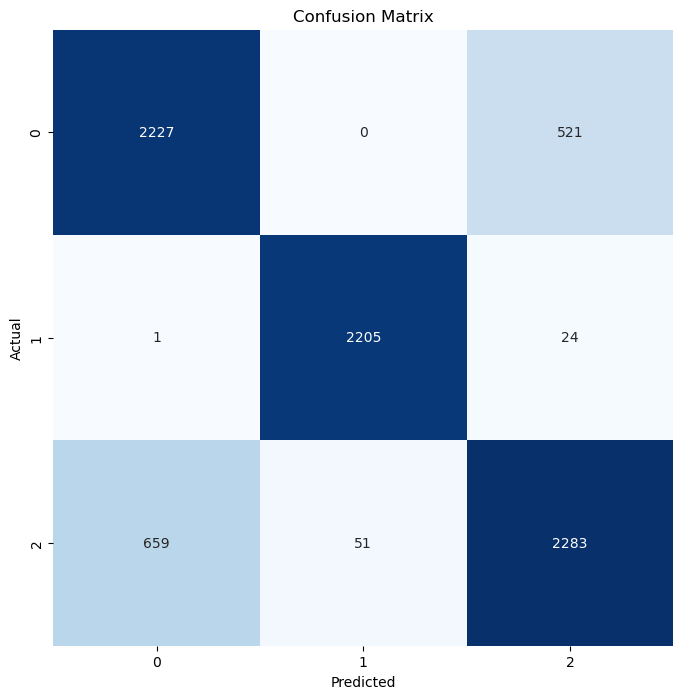

In [15]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cm = confusion_matrix(y2_test, y2_pred_gs)


plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(3) + 0.5)
plt.yticks(np.arange(3) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Prueba de Mejores Modelos con dataset reducido

In [7]:
num_filas = len(df2)
mitad_filas = round(num_filas // 2)
df2_2 = df2.sample(n=mitad_filas, random_state=42)
df2_2.shape

(19927, 12)

### REGRESIÓN (REGRESIÓN LINEAL)

In [10]:
df2_2['clas_pers_PEINAC'] = df2_2['PE_INAC'].apply(clasificar_PEINAC)

In [31]:
columnas_modelos = ['P15A17A', 'P18A24A', 'P18YM_PB']

y1_2_2 = df2[['PE_INAC']].copy()
x1_2_2 = df2[columnas_modelos].copy()

In [32]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1_2_2, y1_2_2, test_size = 0.25, random_state = 777)

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Suponiendo que `x1_train`, `y1_train`, `x1_test`, `y1_test` ya están definidos

parametros = {}

print("REGRESIÓN LINEAL Personas Económicamente Inactivas: ")

grid_search_pea = GridSearchCV(estimator=LinearRegression(), param_grid=parametros, cv=5, verbose=1, scoring='r2')
grid_search_pea.fit(x1_train, y1_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y1_pred_gs = mejor_modelo_pea.predict(x1_test)

y1_pred_gs_rounded = y1_pred_gs.round().astype(int)

# Convertir a unidimensional si es necesario
y1_pred_gs_rounded = y1_pred_gs_rounded.flatten() if isinstance(y1_pred_gs_rounded, np.ndarray) else y1_pred_gs_rounded.values.flatten()
y1_test = y1_test.flatten() if isinstance(y1_test, np.ndarray) else y1_test.values.flatten()

# Predicciones y valores reales
predicciones_reales = pd.DataFrame({'Predicción': y1_pred_gs_rounded[:10], 'Valor Real': y1_test[:10]})
print(predicciones_reales)

# Error Cuadrado Medio
print("Mean squared error: %.3f" % mean_squared_error(y1_test, y1_pred_gs))
# Puntaje de Varianza
print('Variance score: %.3f' % r2_score(y1_test, y1_pred_gs))
R2_2 = r2_score(y1_test, y1_pred_gs)

REGRESIÓN LINEAL Personas Económicamente Inactivas: 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
   Predicción  Valor Real
0          23        49.0
1          52        37.0
2           0         0.0
3          29        28.0
4          29        41.0
5           0         0.0
6           0         0.0
7          21        21.0
8          81        40.0
9           0         0.0
Mean squared error: 578.458
Variance score: 0.842


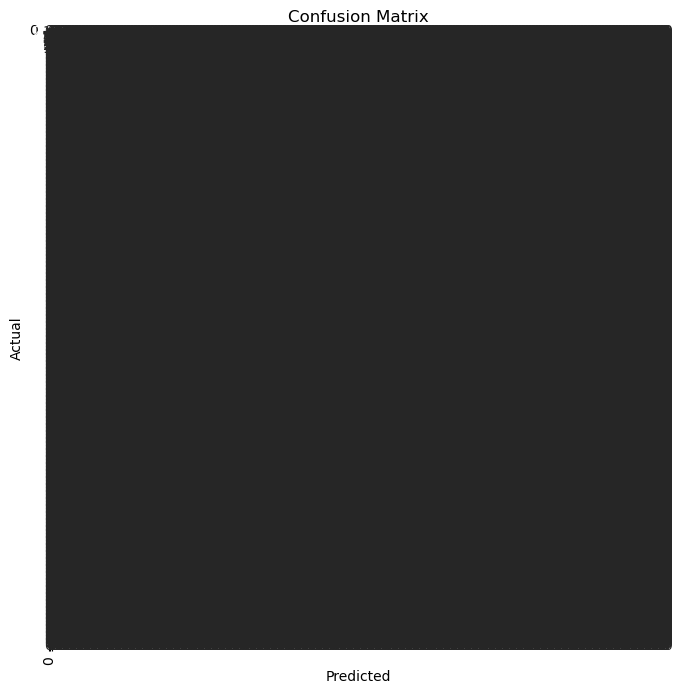

In [24]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cm = confusion_matrix(y1_test, y1_pred_gs_rounded)


plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(3) + 0.5)
plt.yticks(np.arange(3) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### CLASIFICACIÓN (BOSQUES ALEATORIOS)

In [16]:
columnas_modelos = ['P15A17A', 'P18A24A', 'P18YM_PB']

y2_2_2 = df2[['clas_pers_PEINAC']].copy()
x2_2_2 = df2[columnas_modelos].copy()

In [17]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2_2_2, y2_2_2, test_size = 0.25, random_state = 777)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
warnings.filterwarnings("ignore")

parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10, 12, 15],
    'max_features': [3, 6, 9, 12]
}

print("BOSQUES ALEATORIOS Personas Economicamente Activas (CLASIFICACION): ")

grid_search_pea = GridSearchCV(estimator=RandomForestClassifier(random_state=777), param_grid=parameters, cv=5, verbose=1, scoring='accuracy')
grid_search_pea.fit(x2_train, y2_train)

mejores_parametros_pea = grid_search_pea.best_params_
mejor_modelo_pea = grid_search_pea.best_estimator_

y2_pred_gs = mejor_modelo_pea.predict(x2_test)

# Predicciones y valores reales
print("Predicciones vs Valores reales:")
print(classification_report(y2_test, y2_pred_gs))

# Exactitud
print("Exactitud:", accuracy_score(y2_test, y2_pred_gs))
ACURRACY2 = accuracy_score(y2_test, y2_pred_gs)

BOSQUES ALEATORIOS Personas Economicamente Activas (CLASIFICACION): 
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Predicciones vs Valores reales:
              precision    recall  f1-score   support

      Muchas       0.77      0.81      0.79      3451
        NULO       0.98      0.99      0.98      2775
       Pocas       0.80      0.76      0.78      3738

    accuracy                           0.84      9964
   macro avg       0.85      0.85      0.85      9964
weighted avg       0.84      0.84      0.84      9964

Exactitud: 0.8415295062224006


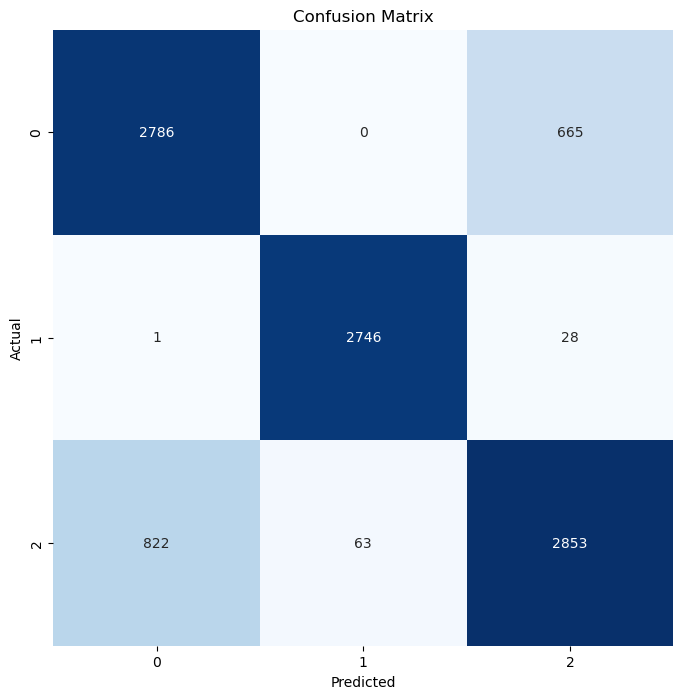

In [21]:
cm = confusion_matrix(y2_test, y2_pred_gs)


plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(3) + 0.5)
plt.yticks(np.arange(3) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## PRUEBA NUEVOS HIPERPARAMETROS (Modelo de Clasificación)

In [20]:
warnings.filterwarnings("ignore")

# Nuevos hiperparámetros
nuevos_parametros = {
    'n_estimators': [10, 20, 40, 80],
    'max_depth': [4, 8, 16, 24, 30],
    'max_features': [3, 6, 12, 20]
}

print("BOSQUES ALEATORIOS Personas Economicamente Activas (CLASIFICACION): ")

nuevo_grid_search_pea = GridSearchCV(estimator=RandomForestClassifier(random_state=777), 
                                     param_grid=nuevos_parametros, cv=5, verbose=1, scoring='accuracy')

nuevo_grid_search_pea.fit(x2_train, y2_train)

nuevos_mejores_parametros_pea = nuevo_grid_search_pea.best_params_
nuevo_mejor_modelo_pea = nuevo_grid_search_pea.best_estimator_

y2_pred_nuevo_gs = nuevo_mejor_modelo_pea.predict(x2_test)

print("Predicciones vs Valores reales con nuevos hiperparámetros:")
print(classification_report(y2_test, y2_pred_nuevo_gs))

nuevo_acurracy2 = accuracy_score(y2_test, y2_pred_nuevo_gs)
print("Exactitud con nuevos hiperparámetros:", nuevo_acurracy2)
ACURRACY3 = accuracy_score(y2_test, y2_pred_nuevo_gs)

BOSQUES ALEATORIOS Personas Economicamente Activas (CLASIFICACION): 
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Predicciones vs Valores reales con nuevos hiperparámetros:
              precision    recall  f1-score   support

      Muchas       0.78      0.81      0.79      3451
        NULO       0.98      0.99      0.98      2775
       Pocas       0.80      0.77      0.79      3738

    accuracy                           0.84      9964
   macro avg       0.85      0.85      0.85      9964
weighted avg       0.84      0.84      0.84      9964

Exactitud con nuevos hiperparámetros: 0.8426334805299077


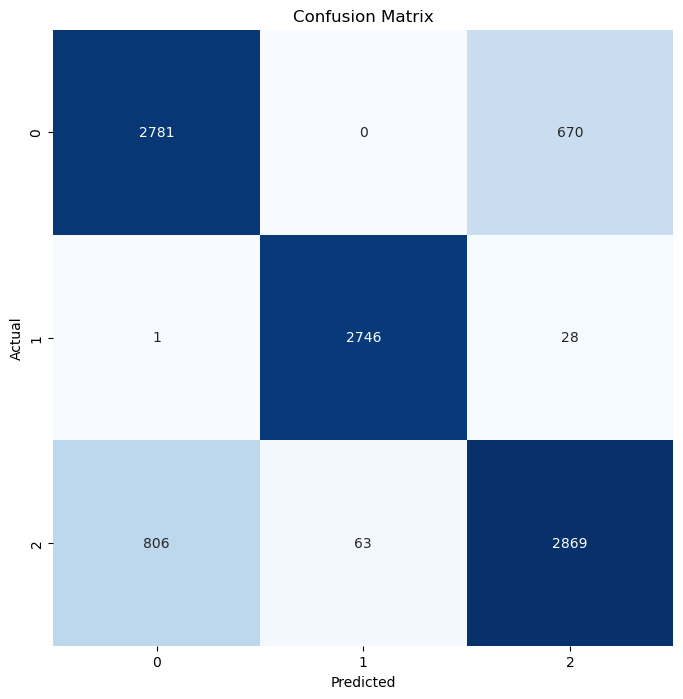

In [22]:
cm = confusion_matrix(y2_test, y2_pred_nuevo_gs)


plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(3) + 0.5)
plt.yticks(np.arange(3) + 0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### TABLA COMPARATIVA

In [38]:
data = {
    'Variable': ['REGRESION LINEAL 1', 'BOSQUES ALEATORIOS 1', 'BOSQUES ALEATORIOS 2', 'BOSQUES ALEATORIOS 3', 'BOSQUES ALEATORIOS 4'],
    'Resultado': [R2_1, R2_2, ACURRACY1, ACURRACY2, ACURRACY3]
}

TABLA = pd.DataFrame(data)

# Muestra el DataFrame
print(TABLA)

               Variable  Resultado
0    REGRESION LINEAL 1   0.841357
1  BOSQUES ALEATORIOS 1   0.842445
2  BOSQUES ALEATORIOS 2   0.842429
3  BOSQUES ALEATORIOS 3   0.841530
4  BOSQUES ALEATORIOS 4   0.842633


## Prototipo APLICACIÓN

In [39]:
from dash import Dash, dcc, html, Input, Output, State
import plotly.graph_objs as go
import pickle

app = Dash()

app.layout = html.Div(children=[
    html.H1(children='Modelo predictivo de Poblacion Economicamente Inactiva', style={'textAlign': 'center', 'textDecoration': 'underline', 'fontStyle': 'italic'}),
    html.H2(children='Basado en Escolaridad por Zonas', style={'textAlign': 'center', 'color':'blue'}),
    html.Div(children=[
        html.P([
          html.Label('Población de 15 a 17 años que asiste a la escuela: '),
          dcc.Input(id='P15A17A', placeholder='# de Personas: ', type='text')
        ]),
        html.P([
          html.Label('Población de 18 a 24 años que asiste a la escuela: '),
          dcc.Input(id='P18A24A', placeholder='# de Personas: ', type='text')
        ]),
        html.P([
          html.Label('Población de 18 años y mas con educacion posbásica: '),
          dcc.Input(id='P18YM_PB', placeholder='# de Personas: ', type='text')
        ]),
        html.Button(id='submit-button', n_clicks=0, children='Realizar Predicción'),
        html.P([
           html.Label('Cantidad de personas economicamente inactivas: $'),
           dcc.Input(value='0', type='text', id='pred')
        ]),
        html.Div(id='result'),
        
        html.P([
          html.Label('NULO = 0, Pocos: ≤ 35 , Muchos: > 35') 
        ]),
    ], style={'textAlign': 'center'})

])

@app.callback(
    Output(component_id='pred', component_property='value'),
    [Input('submit-button', 'n_clicks'),
    State(component_id='P15A17A', component_property='value'),
    State(component_id='P18A24A', component_property='value'),
    State(component_id='P18YM_PB', component_property='value')]
    )
def prediction(n_clicks,P15A17A,P18A24A,P18YM_PB):
    if P15A17A != None and  P18A24A != None and P18YM_PB != None:
        try:
            nombre_archivo='mejor_modelo_pe_inac.pkl'
            archivo_entrada=open(nombre_archivo,'rb')
            mejor_modelo_pe_inac=pickle.load(archivo_entrada)
            archivo_entrada.close()
            prediccion = mejor_modelo_pe_inac.predict([[P15A17A, P18A24A, P18YM_PB]])
            return prediccion[0]
        except ValueError:
            return 'Error de Valor en Inputs'

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)
